In [1]:
# ---------------------------------------------------------------------------------------------
# MODULES
# ---------------------------------------------------------------------------------------------
from python_functions_sklearn import Contingency_table, CT_metrics, compute_roc
import os
import seaborn2 as sns
import pandas as pd
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy

In [2]:
# ---------------------------------------------------------------------------------------------
# SET DETAILS FIGURES
# ---------------------------------------------------------------------------------------------
font_title = 20
font_subtitle = 16
font_axes = 14
font_ticklabels = 12
font_text = 12
font_legend = 12

# colorblind proof:
palette = sns.color_palette('colorblind')

color_ref = palette[0]
color_exp = 'tab:brown'
ls_exp = '--'

In [3]:
# ---------------------------------------------------------------------------------------------
# SPECIFY TIER AND CORRESPONDING PATHS
# ---------------------------------------------------------------------------------------------
Tier = 'Hortense'

if Tier == 'Hortense':
    path_ref = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Reference'
    path_out = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Fire_data'
    path_figs = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

elif Tier == 'Genius':
    path_ref = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Reference'
    path_out = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Fire_data'
    path_figs = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

else:
    print('Error: Tier can only be Hortense or Genius.')

peatland_types = ['TN', 'TD']
CDF_types = ['pixel']

In [4]:
# ---------------------------------------------------------------------------------------------
# LOAD FIRE DATASET
# ---------------------------------------------------------------------------------------------
fires_file = os.path.join(path_fires, 'Reformatted_table_Tim.csv')

fires = pd.read_csv(fires_file, header=0)
fires['start_date'] = pd.to_datetime(fires['start_date'])
# only get those fires that are in our domain and in peatclsm pixels:
fire_data = fires[fires['Drained_I'] >= 0].reset_index(drop=True)

times = pd.date_range('2002-01-01', '2018-12-31', freq='D')

fire_dates = pd.DatetimeIndex(fire_data.start_date)
fire_data = fire_data[fire_dates.year >= 2002].reset_index(drop=True)
fire_dates = fire_dates[fire_dates.year >= 2002]

fires_nat = dcopy(fire_data)
fires_nat = fires_nat[fires_nat['Drained_I'] == 0].reset_index(drop=True)
fire_nat_dates = pd.DatetimeIndex(fires_nat.start_date)
fire_nat_dates = fire_nat_dates[fire_nat_dates.year >= 2002]
fires_dra = dcopy(fire_data)
fires_dra = fires_dra[fires_dra['Drained_I'] == 1].reset_index(drop=True)
fire_dra_dates = pd.DatetimeIndex(fires_dra.start_date)
fire_dra_dates = fire_dra_dates[fire_dra_dates.year >= 2002]

In [5]:
# ---------------------------------------------------------------------------------------------
# LOAD FWI DATASETS
# ---------------------------------------------------------------------------------------------
## Natural
# Reference:
ds_ref_nat = Dataset(os.path.join(path_ref, 'FWI_masked_Nat.nc'), 'r')
FWI_M2_nat = ds_ref_nat['MERRA2_FWI'][0:6209, :, :].data
DC_M2_nat = ds_ref_nat['MERRA2_DC'][0:6209, :, :].data

# EXP3b:
ds_EXP3b_nat = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TN_pixel.nc'), 'r')
FWI_EXP3b_nat = ds_EXP3b_nat['MERRA2_FWI'][0:6209, :, :].data

ds_zbar_nat = Dataset(os.path.join(path_peatlands, 'PEATCLSM_TN_masked_Nat_20022018.nc'), 'r')
zbar_nat = ds_zbar_nat['zbar'][0:6209, :, :].data

## Drained
# Reference:
ds_ref_dra = Dataset(os.path.join(path_ref, 'FWI_masked_Dra.nc'), 'r')
FWI_M2_dra = ds_ref_dra['MERRA2_FWI'][0:6209, :, :].data
DC_M2_dra = ds_ref_dra['MERRA2_DC'][0:6209, :, :].data

# EXP3b:
ds_EXP3b_dra = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TD_pixel.nc'), 'r')
FWI_EXP3b_dra = ds_EXP3b_dra['MERRA2_FWI'][0:6209, :, :].data

ds_zbar_dra = Dataset(os.path.join(path_peatlands, 'PEATCLSM_TD_masked_Dra_20022018.nc'), 'r')
zbar_dra = ds_zbar_dra['zbar'][0:6209, :, :].data

In [6]:
# ---------------------------------------------------------------------------------------------
# CREATE RASTER OF FIRE DATASET
# ---------------------------------------------------------------------------------------------
lats = ds_ref_nat['lat'][:]
lons = ds_ref_nat['lon'][:]

# Determine the dimensions of the dataset:
dim_time_nat = FWI_M2_nat.shape[0]
dim_lat_nat = FWI_M2_nat.shape[1]
dim_lon_nat = FWI_M2_nat.shape[2]

dim_time_dra = FWI_M2_dra.shape[0]
dim_lat_dra = FWI_M2_dra.shape[1]
dim_lon_dra = FWI_M2_dra.shape[2]

# Create raster of natural fires
fires_raster_nat = np.zeros((dim_time_nat, dim_lat_nat, dim_lon_nat))
for i in range(len(fires_nat.latitude_I)):
    time_start = (pd.to_datetime(fires_nat['start_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    end_time = (pd.to_datetime(fires_nat['end_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    lat_diffs = abs(lats - fires_nat['latitude_P'][i])
    lon_diffs = abs(lons - fires_nat['longitude_P'][i])

    lat_inds = np.where(lat_diffs == np.nanmin(lat_diffs))
    lon_inds = np.where(lon_diffs == np.nanmin(lon_diffs))

    fires_raster_nat[time_start:end_time, lat_inds, lon_inds] += 1

fires_raster_nat[fires_raster_nat > 1] = 1  # For the calculation of the ROC curve, binary data is needed

# Create raster of drained fires
lat_diffs = []
lon_diffs = []
i = 0
lat_inds = []
lon_inds = []

fires_raster_dra = np.zeros((dim_time_dra, dim_lat_dra, dim_lon_dra))
for i in range(len(fires_dra.latitude_I)):
    time_start = (pd.to_datetime(fires_dra['start_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    end_time = (pd.to_datetime(fires_dra['end_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    lat_diffs = abs(lats - fires_dra['latitude_I'][i])
    lon_diffs = abs(lons - fires_dra['longitude_I'][i])

    lat_inds = np.where(lat_diffs == np.nanmin(lat_diffs))
    lon_inds = np.where(lon_diffs == np.nanmin(lon_diffs))

    fires_raster_dra[time_start:end_time, lat_inds, lon_inds] += 1

fires_raster_dra[fires_raster_dra > 1] = 1  # For the calculation of the ROC curve, binary data is needed

In [7]:
# ---------------------------------------------------------------------------------------------
# PREPARE DATASETS FOR CALCULATION OF ROC
# ---------------------------------------------------------------------------------------------
nonan_M2_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_M2_nat)))
nonan_DC_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(DC_M2_nat)))
nonan_EXP3b_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP3b_nat)))
nonan_zbar_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(zbar_nat)))

nonan_M2_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_M2_dra)))
nonan_DC_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(DC_M2_dra)))
nonan_EXP3b_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP3b_dra)))
nonan_zbar_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(zbar_dra)))

In [8]:
# ---------------------------------------------------------------------------------------------
# CALCULATE 90th PERCENTILE THRESHOLD
# ---------------------------------------------------------------------------------------------
threshold_M2_nat = np.nanquantile(FWI_M2_nat, 0.9)
threshold_DC_nat = np.nanquantile(DC_M2_nat, 0.9)
threshold_EXP3b_nat = np.nanquantile(FWI_EXP3b_nat, 0.9)

threshold_M2_dra = np.nanquantile(FWI_M2_dra, 0.9)
threshold_DC_dra = np.nanquantile(DC_M2_dra, 0.9)
threshold_EXP3b_dra = np.nanquantile(FWI_EXP3b_dra, 0.9)

In [9]:
'''
INTERMEZZO:
For which FWI class (low, medium, high or extreme) does the FWI_peat not improve the predictions?
Low: 0-2
Medium: 2-6
High: 7-13
Extreme: >13
'''

# ---------------------------------------------------------------------------------------------
# CALCULATE CORRESPONDING TPR AND FPR
# ---------------------------------------------------------------------------------------------
## Natural
# Start with the contingency table:
A_M2_nat_med, B_M2_nat_med, C_M2_nat_med, D_M2_nat_med = Contingency_table(FWI_M2_nat, fires_raster_nat, 2, 1)
A_DC_nat_med, B_DC_nat_med, C_DC_nat_med, D_DC_nat_med = Contingency_table(DC_M2_nat, fires_raster_nat, 2, 1)
A_EXP3b_nat_med, B_EXP3b_nat_med, C_EXP3b_nat_med, D_EXP3b_nat_med = Contingency_table(FWI_EXP3b_nat, fires_raster_nat, 2, 1)

# Then the TPR and FPR:
TPR_M2_nat_med, _, _, _, _, FPR_M2_nat_med = CT_metrics(A_M2_nat_med, B_M2_nat_med, C_M2_nat_med, D_M2_nat_med)
TPR_DC_nat_med, _, _, _, _, FPR_DC_nat_med = CT_metrics(A_DC_nat_med, B_DC_nat_med, C_DC_nat_med, D_DC_nat_med)
TPR_EXP3b_nat_med, _, _, _, _, FPR_EXP3b_nat_med = CT_metrics(A_EXP3b_nat_med, B_EXP3b_nat_med, C_EXP3b_nat_med, D_EXP3b_nat_med)

A_M2_nat_high, B_M2_nat_high, C_M2_nat_high, D_M2_nat_high = Contingency_table(FWI_M2_nat, fires_raster_nat, 7, 1)
A_DC_nat_high, B_DC_nat_high, C_DC_nat_high, D_DC_nat_high = Contingency_table(DC_M2_nat, fires_raster_nat, 7, 1)
A_EXP3b_nat_high, B_EXP3b_nat_high, C_EXP3b_nat_high, D_EXP3b_nat_high = Contingency_table(FWI_EXP3b_nat, fires_raster_nat, 7, 1)

# Then the TPR and FPR:
TPR_M2_nat_high, _, _, _, _, FPR_M2_nat_high = CT_metrics(A_M2_nat_high, B_M2_nat_high, C_M2_nat_high, D_M2_nat_high)
TPR_DC_nat_high, _, _, _, _, FPR_DC_nat_high = CT_metrics(A_DC_nat_high, B_DC_nat_high, C_DC_nat_high, D_DC_nat_high)
TPR_EXP3b_nat_high, _, _, _, _, FPR_EXP3b_nat_high = CT_metrics(A_EXP3b_nat_high, B_EXP3b_nat_high, C_EXP3b_nat_high, D_EXP3b_nat_high)

A_M2_nat_ext, B_M2_nat_ext, C_M2_nat_ext, D_M2_nat_ext = Contingency_table(FWI_M2_nat, fires_raster_nat, 13, 1)
A_DC_nat_ext, B_DC_nat_ext, C_DC_nat_ext, D_DC_nat_ext = Contingency_table(DC_M2_nat, fires_raster_nat, 13, 1)
A_EXP3b_nat_ext, B_EXP3b_nat_ext, C_EXP3b_nat_ext, D_EXP3b_nat_ext = Contingency_table(FWI_EXP3b_nat, fires_raster_nat, 13, 1)

# Then the TPR and FPR:
TPR_M2_nat_ext, _, _, _, _, FPR_M2_nat_ext = CT_metrics(A_M2_nat_ext, B_M2_nat_ext, C_M2_nat_ext, D_M2_nat_ext)
TPR_DC_nat_ext, _, _, _, _, FPR_DC_nat_ext = CT_metrics(A_DC_nat_ext, B_DC_nat_ext, C_DC_nat_ext, D_DC_nat_ext)
TPR_EXP3b_nat_ext, _, _, _, _, FPR_EXP3b_nat_ext = CT_metrics(A_EXP3b_nat_ext, B_EXP3b_nat_ext, C_EXP3b_nat_ext, D_EXP3b_nat_ext)

## Drained
# Start with the contingency table:
A_M2_dra_med, B_M2_dra_med, C_M2_dra_med, D_M2_dra_med = Contingency_table(FWI_M2_dra, fires_raster_dra, 2, 1)
A_DC_dra_med, B_DC_dra_med, C_DC_dra_med, D_DC_dra_med = Contingency_table(DC_M2_dra, fires_raster_dra, 2, 1)
A_EXP3b_dra_med, B_EXP3b_dra_med, C_EXP3b_dra_med, D_EXP3b_dra_med = Contingency_table(FWI_EXP3b_dra, fires_raster_dra, 2, 1)

# Then the TPR and FPR:
TPR_M2_dra_med, _, _, _, _, FPR_M2_dra_med = CT_metrics(A_M2_dra_med, B_M2_dra_med, C_M2_dra_med, D_M2_dra_med)
TPR_DC_dra_med, _, _, _, _, FPR_DC_dra_med = CT_metrics(A_DC_dra_med, B_DC_dra_med, C_DC_dra_med, D_DC_dra_med)
TPR_EXP3b_dra_med, _, _, _, _, FPR_EXP3b_dra_med = CT_metrics(A_EXP3b_dra_med, B_EXP3b_dra_med, C_EXP3b_dra_med, D_EXP3b_dra_med)

A_M2_dra_high, B_M2_dra_high, C_M2_dra_high, D_M2_dra_high = Contingency_table(FWI_M2_dra, fires_raster_dra, 7, 1)
A_DC_dra_high, B_DC_dra_high, C_DC_dra_high, D_DC_dra_high = Contingency_table(DC_M2_dra, fires_raster_dra, 7, 1)
A_EXP3b_dra_high, B_EXP3b_dra_high, C_EXP3b_dra_high, D_EXP3b_dra_high = Contingency_table(FWI_EXP3b_dra, fires_raster_dra, 7, 1)

# Then the TPR and FPR:
TPR_M2_dra_high, _, _, _, _, FPR_M2_dra_high = CT_metrics(A_M2_dra_high, B_M2_dra_high, C_M2_dra_high, D_M2_dra_high)
TPR_DC_dra_high, _, _, _, _, FPR_DC_dra_high = CT_metrics(A_DC_dra_high, B_DC_dra_high, C_DC_dra_high, D_DC_dra_high)
TPR_EXP3b_dra_high, _, _, _, _, FPR_EXP3b_dra_high = CT_metrics(A_EXP3b_dra_high, B_EXP3b_dra_high, C_EXP3b_dra_high, D_EXP3b_dra_high)

A_M2_dra_ext, B_M2_dra_ext, C_M2_dra_ext, D_M2_dra_ext = Contingency_table(FWI_M2_dra, fires_raster_dra, 13, 1)
A_DC_dra_ext, B_DC_dra_ext, C_DC_dra_ext, D_DC_dra_ext = Contingency_table(DC_M2_dra, fires_raster_dra, 13, 1)
A_EXP3b_dra_ext, B_EXP3b_dra_ext, C_EXP3b_dra_ext, D_EXP3b_dra_ext = Contingency_table(FWI_EXP3b_dra, fires_raster_dra, 13, 1)

# Then the TPR and FPR:
TPR_M2_dra_ext, _, _, _, _, FPR_M2_dra_ext = CT_metrics(A_M2_dra_ext, B_M2_dra_ext, C_M2_dra_ext, D_M2_dra_ext)
TPR_DC_dra_ext, _, _, _, _, FPR_DC_dra_ext = CT_metrics(A_DC_dra_ext, B_DC_dra_ext, C_DC_dra_ext, D_DC_dra_ext)
TPR_EXP3b_dra_ext, _, _, _, _, FPR_EXP3b_dra_ext = CT_metrics(A_EXP3b_dra_ext, B_EXP3b_dra_ext, C_EXP3b_dra_ext, D_EXP3b_dra_ext)

'''
-----------------
End of intermezzo
-----------------
'''

'\n-----------------\nEnd of intermezzo\n-----------------\n'

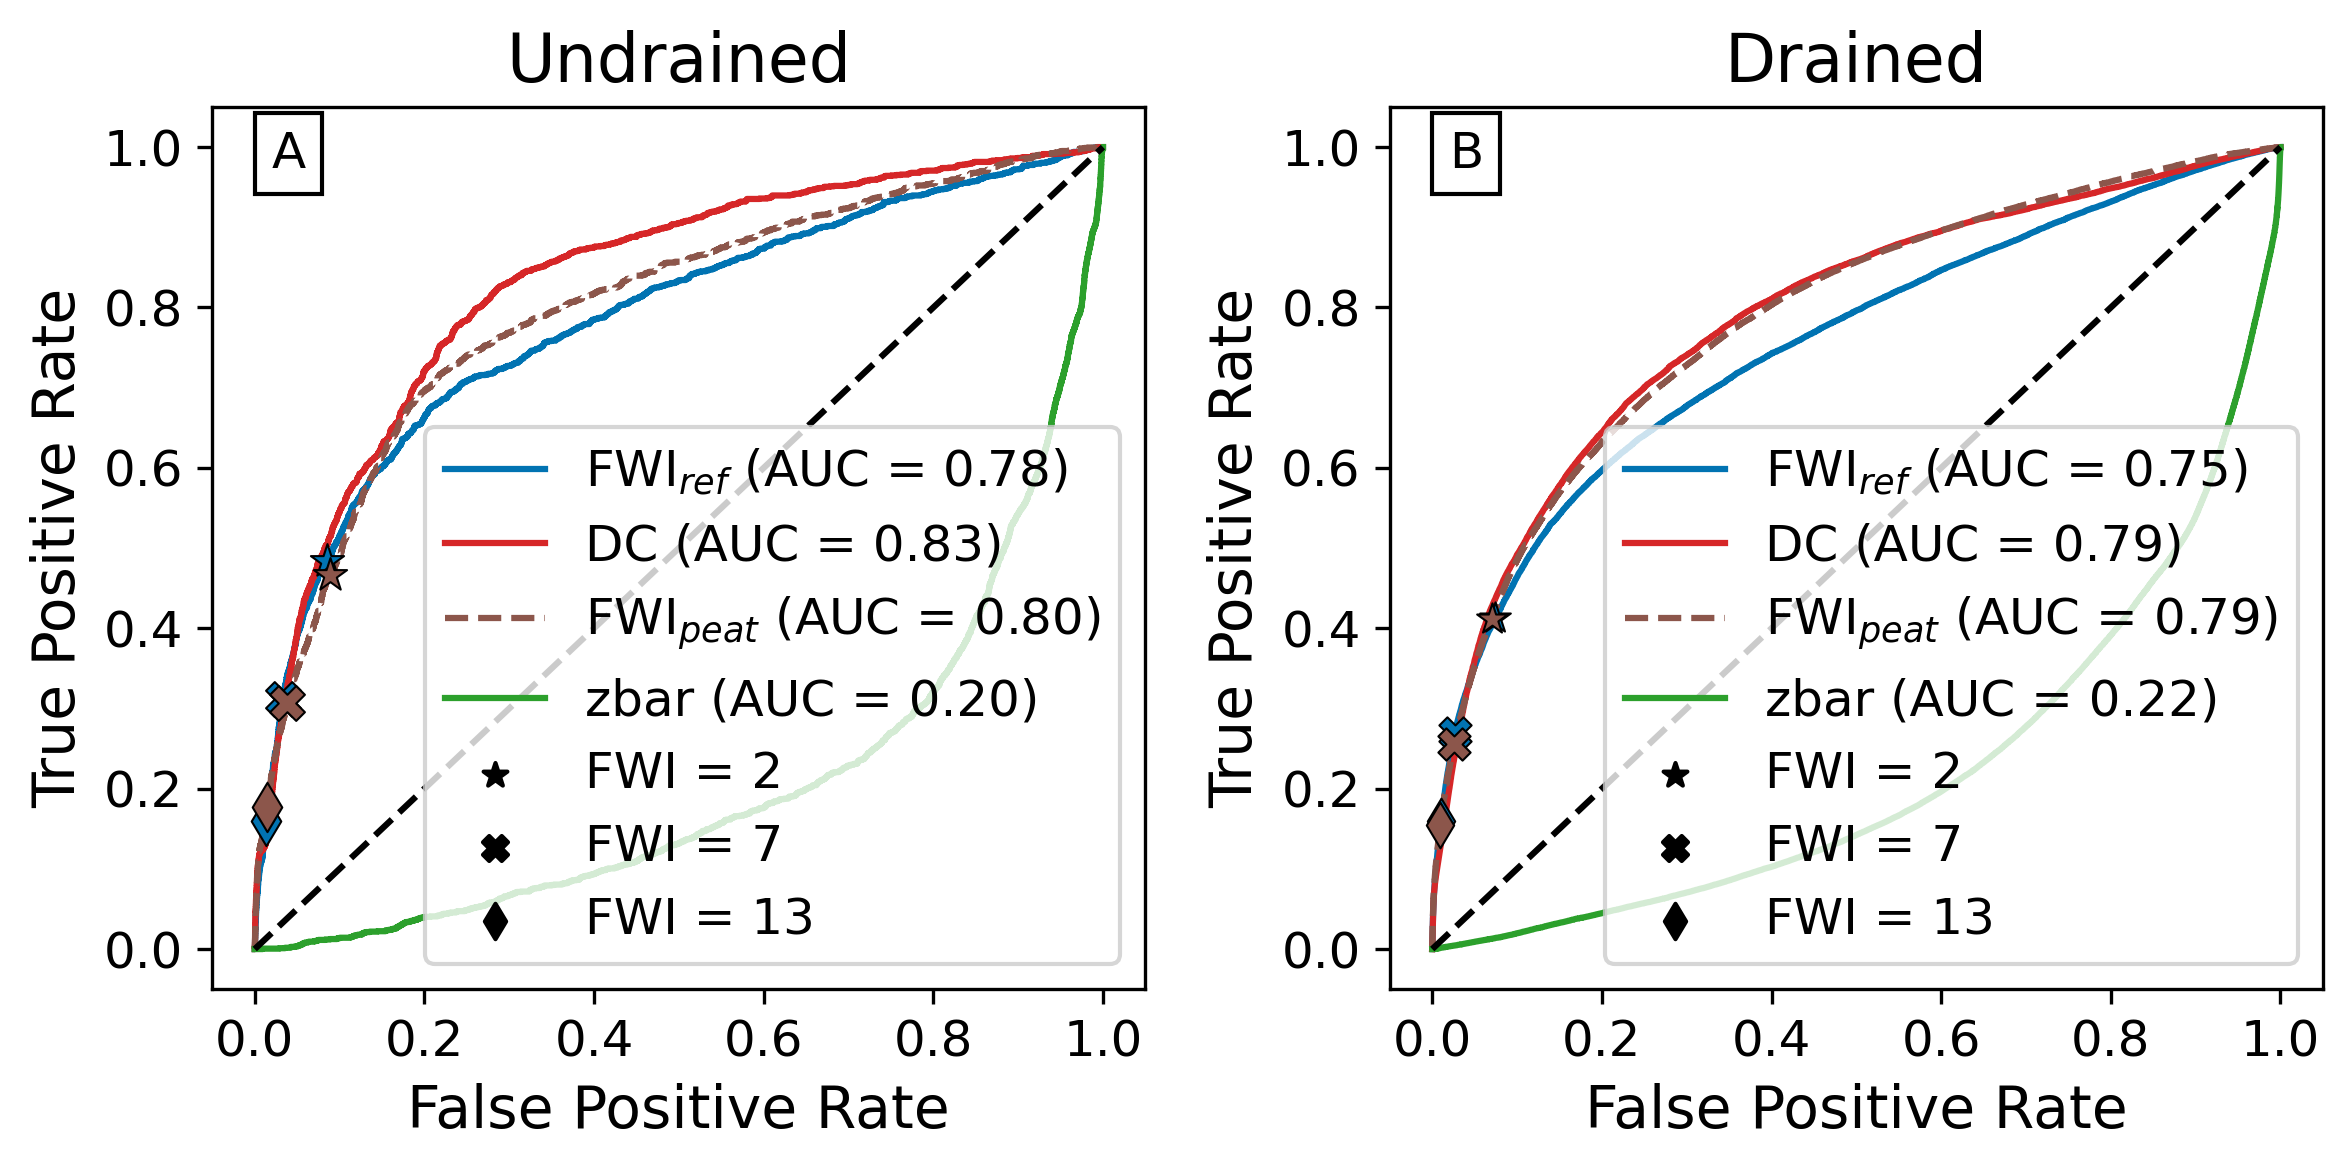

In [10]:
'''-------------------------------------------------Plotting-------------------------------------------------'''
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
# ---------------------------------------------------------------------------------------------
# NATURAL PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_nat, tpr_M2_nat, thresholds_M2_nat, auc_M2_nat = compute_roc(
    fires_raster_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten(), 
    FWI_M2_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten())
axes[0].plot(fpr_M2_nat, tpr_M2_nat, color=color_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_nat)

## DC
fpr_DC_nat, tpr_DC_nat, thresholds_DC_nat, auc_DC_nat = compute_roc(
    fires_raster_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten(), 
    DC_M2_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten())
axes[0].plot(fpr_DC_nat, tpr_DC_nat, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_nat)

## EXP3b:
fpr_EXP3b_nat, tpr_EXP3b_nat, thresholds_EXP3b_nat, auc_EXP3b_nat = compute_roc(
    fires_raster_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten(), 
    FWI_EXP3b_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten())
axes[0].plot(fpr_EXP3b_nat, tpr_EXP3b_nat, color=color_exp, ls=ls_exp, label='FWI$_{peat}$ (AUC = %0.2f)' % auc_EXP3b_nat)

## zbar
fpr_zbar_nat, tpr_zbar_nat, thresholds_zbar_nat, auc_zbar_nat = compute_roc(
    fires_raster_nat[nonan_zbar_nat[:, 0], nonan_zbar_nat[:, 1], nonan_zbar_nat[:, 2]].flatten(), 
    zbar_nat[nonan_zbar_nat[:, 0], nonan_zbar_nat[:, 1], nonan_zbar_nat[:, 2]].flatten())
axes[0].plot(fpr_zbar_nat, tpr_zbar_nat, color='tab:green', label='zbar (AUC = %0.2f)' % auc_zbar_nat)

# Plot TPR and FPR of medium:
## Reference:
axes[0].scatter(FPR_M2_nat_med, TPR_M2_nat_med, color=color_ref, marker='*', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[0].scatter(FPR_EXP3b_nat_med, TPR_EXP3b_nat_med, color=color_exp, marker='*', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

# Plot TPR and FPR of high:
## Reference:
axes[0].scatter(FPR_M2_nat_high, TPR_M2_nat_high, color=color_ref, marker='X', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[0].scatter(FPR_EXP3b_nat_high, TPR_EXP3b_nat_high, color=color_exp, marker='X', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

# Plot TPR and FPR of extreme:
## Reference:
axes[0].scatter(FPR_M2_nat_ext, TPR_M2_nat_ext, color=color_ref, marker='d', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[0].scatter(FPR_EXP3b_nat_ext, TPR_EXP3b_nat_ext, color=color_exp, marker='d', s=70, edgecolor='k', linewidths=0.5, zorder=2.5)

# Beautify the plot:
axes[0].set_title('Undrained', fontsize=font_subtitle)
axes[0].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

# Add the symbols to the legend:
axes[0].scatter([], [], c='k', marker='*', label='FWI = 2')
axes[0].scatter([], [], c='k', marker='X', label='FWI = 7')
axes[0].scatter([], [], c='k', marker='d', label='FWI = 13')

axes[0].set_xlabel('False Positive Rate', fontsize=font_axes)
axes[0].set_ylabel('True Positive Rate', fontsize=font_axes)
axes[0].legend(fontsize=font_legend, loc='lower right')
axes[0].tick_params(axis='both', labelsize=font_ticklabels)

# ---------------------------------------------------------------------------------------------
# DRAINED PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_dra, tpr_M2_dra, thresholds_M2_dra, auc_M2_dra = compute_roc(
    fires_raster_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten(), 
    FWI_M2_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten())
axes[1].plot(fpr_M2_dra, tpr_M2_dra, color=color_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_dra)

## DC:
fpr_DC_dra, tpr_DC_dra, thresholds_DC_dra, auc_DC_dra = compute_roc(
    fires_raster_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten(), 
    DC_M2_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten())
axes[1].plot(fpr_DC_dra, tpr_DC_dra, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_dra)

## EXP3b:
fpr_EXP3b_dra, tpr_EXP3b_dra, thresholds_EXP3b_dra, auc_EXP3b_dra = compute_roc(
    fires_raster_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten(), 
    FWI_EXP3b_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten())
axes[1].plot(fpr_EXP3b_dra, tpr_EXP3b_dra, color=color_exp, ls=ls_exp, label='FWI$_{peat}$ (AUC = %0.2f)' % auc_EXP3b_dra)

## zbar:
fpr_zbar_dra, tpr_zbar_dra, thresholds_zbar_dra, auc_zbar_dra = compute_roc(
    fires_raster_dra[nonan_zbar_dra[:, 0], nonan_zbar_dra[:, 1], nonan_zbar_dra[:, 2]].flatten(), 
    zbar_dra[nonan_zbar_dra[:, 0], nonan_zbar_dra[:, 1], nonan_zbar_dra[:, 2]].flatten())
axes[1].plot(fpr_zbar_dra, tpr_zbar_dra, color='tab:green', label='zbar (AUC = %0.2f)' % auc_zbar_dra)

# Plot TPR and FPR of medium:
## Reference:
axes[1].scatter(FPR_M2_dra_med, TPR_M2_dra_med, color=color_ref, marker='*', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[1].scatter(FPR_EXP3b_dra_med, TPR_EXP3b_dra_med, color=color_exp, marker='*', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

# Plot TPR and FPR of high:
## Reference:
axes[1].scatter(FPR_M2_dra_high, TPR_M2_dra_high, color=color_ref, marker='X', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[1].scatter(FPR_EXP3b_dra_high, TPR_EXP3b_dra_high, color=color_exp, marker='X', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

# Plot TPR and FPR of extreme:
## Reference:
axes[1].scatter(FPR_M2_dra_ext, TPR_M2_dra_ext, color=color_ref, marker='d', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

## EXP3b:
axes[1].scatter(FPR_EXP3b_dra_ext, TPR_EXP3b_dra_ext, color=color_exp, marker='d', s=60, edgecolor='k', linewidths=0.5, zorder=2.5)

# Add the symbols to the legend:
axes[1].scatter([], [], c='k', marker='*', label='FWI = 2')
axes[1].scatter([], [], c='k', marker='X', label='FWI = 7')
axes[1].scatter([], [], c='k', marker='d', label='FWI = 13')

# Beautify the plot:
axes[1].set_title('Drained', fontsize=font_subtitle)
axes[1].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

axes[1].set_xlabel('False Positive Rate', fontsize=font_axes)
axes[1].set_ylabel('True Positive Rate', fontsize=font_axes)
axes[1].legend(fontsize=font_legend, loc='lower right')
axes[1].tick_params(axis='both', labelsize=font_ticklabels)

fig.tight_layout()

# Add a, b, c, etc to the figures
first = 'A'
second = 'B'

plt.text(0.1, 0.92, first, bbox=dict(facecolor='white', alpha=1.0), horizontalalignment='right',
         verticalalignment='bottom', transform=axes[0].transAxes, fontsize=font_text)
plt.text(0.1, 0.92, second, bbox=dict(facecolor='white', alpha=1.0), horizontalalignment='right',
         verticalalignment='bottom', transform=axes[1].transAxes, fontsize=font_text)

plt.savefig(os.path.join(path_figs, 'ROC_EXP3b'))
# plt.show()

/tmp/ipykernel_430186/462004376.py:79: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


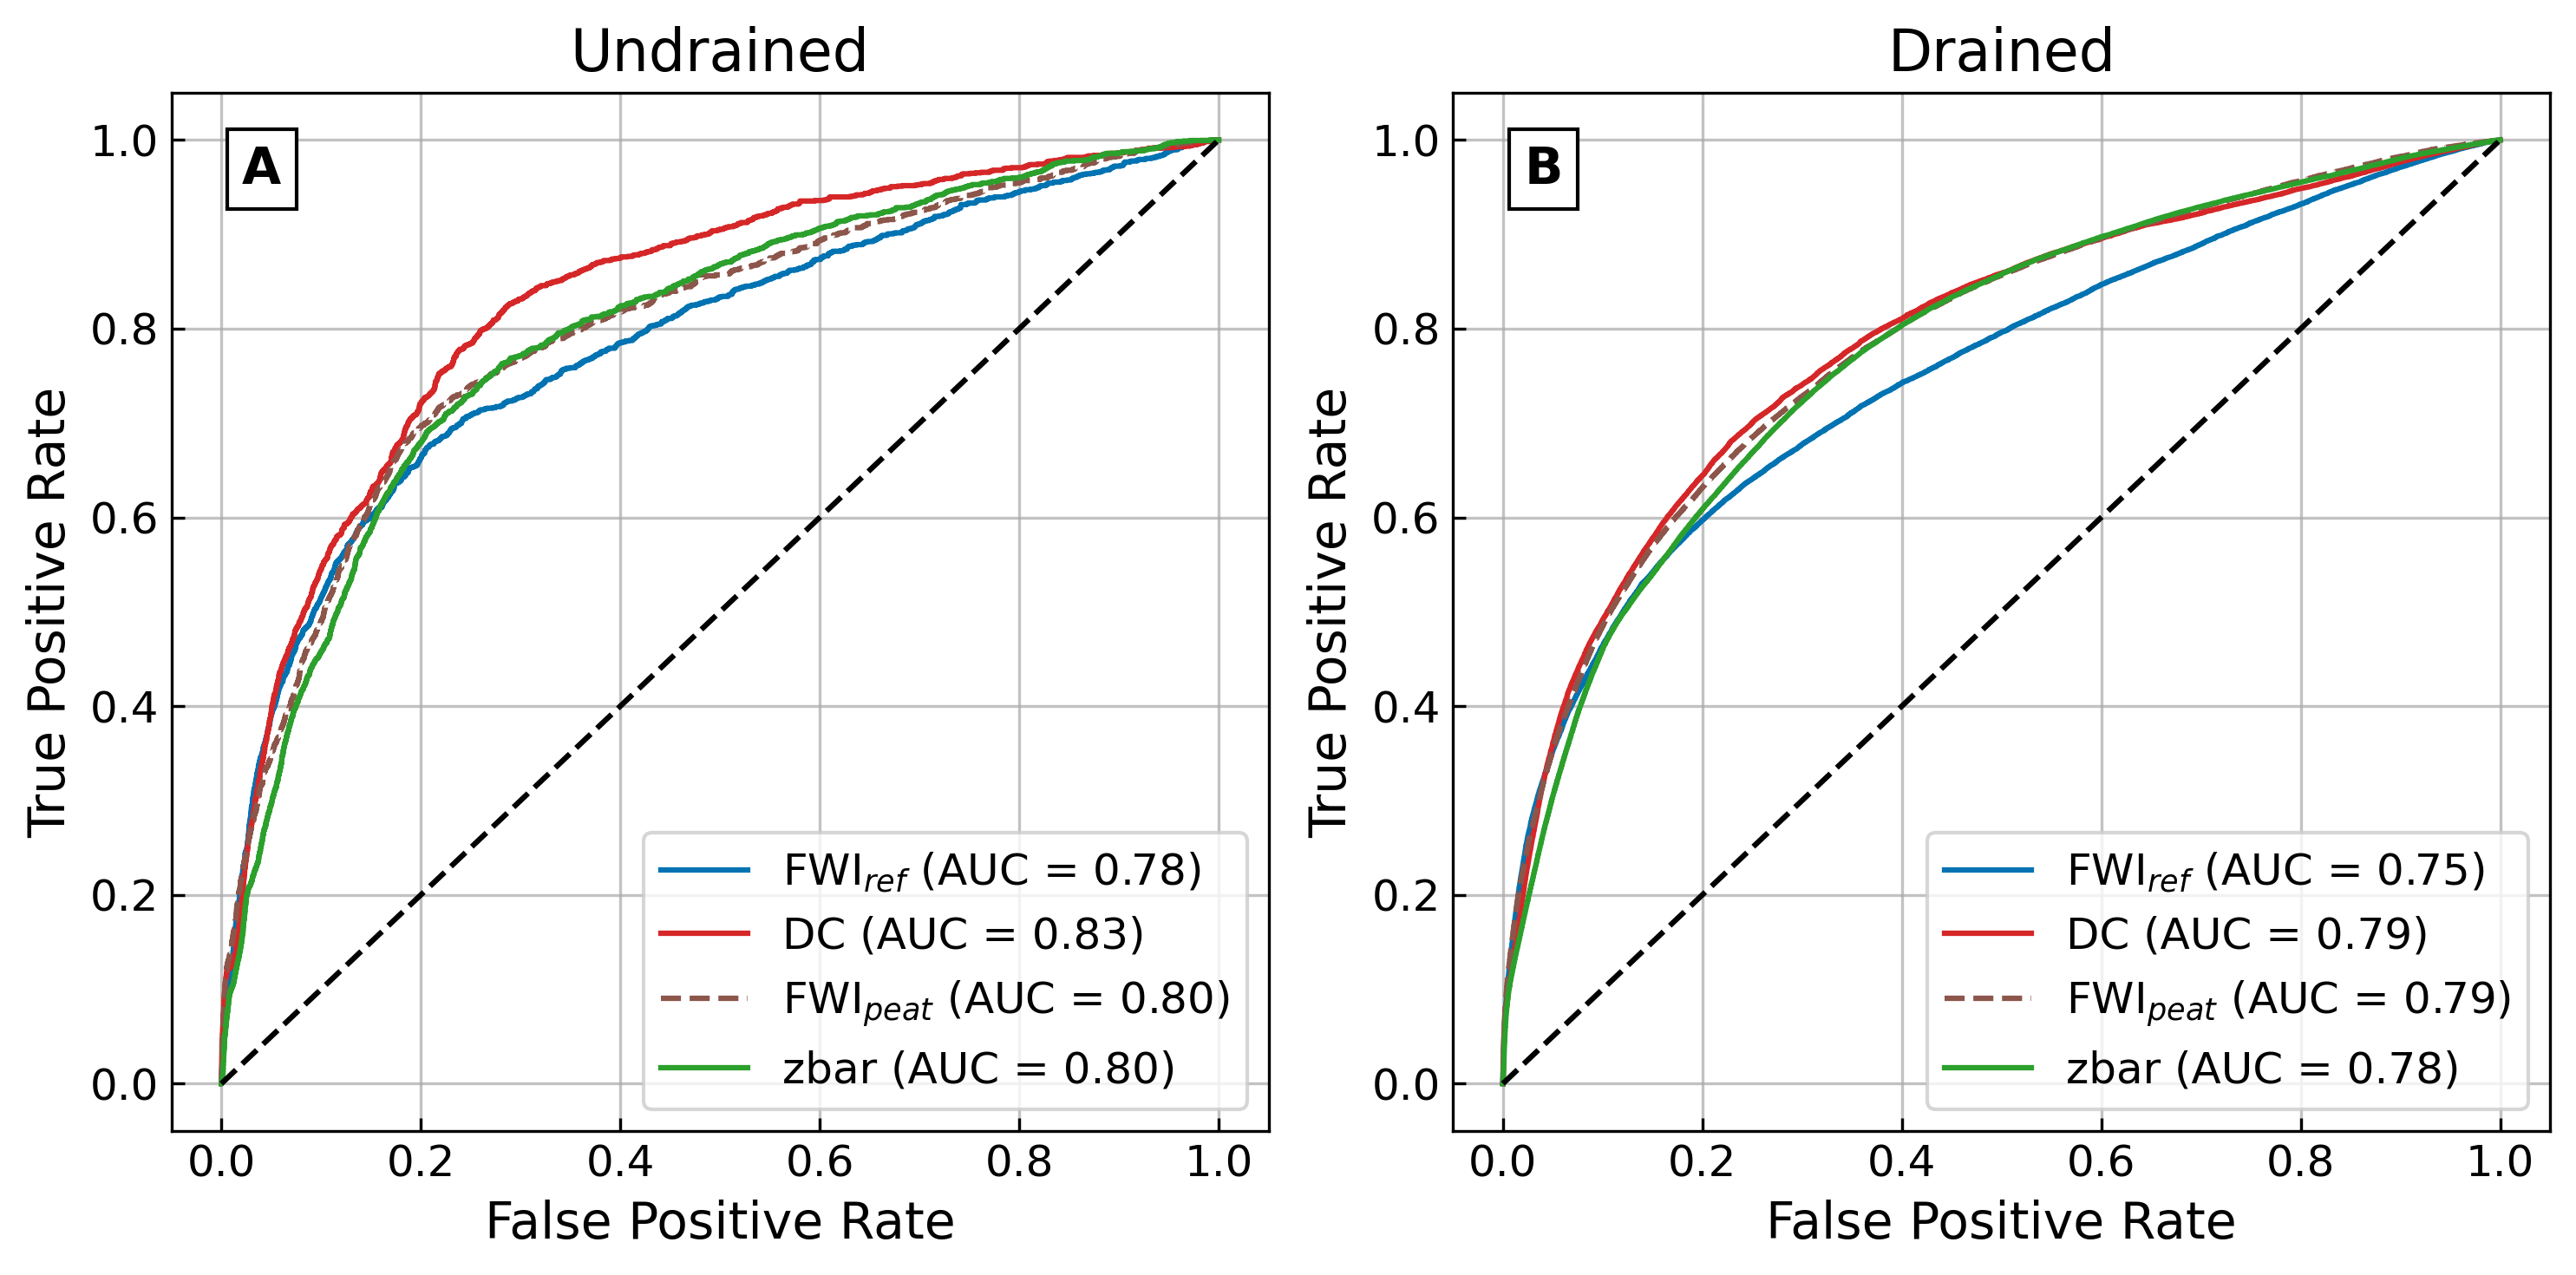

In [11]:
fig = plt.figure(layout='constrained', figsize=(10,5), dpi=300)
ax = fig.subplot_mosaic(
    """
    AB
    """
)
# ---------------------------------------------------------------------------------------------
# NATURAL PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_nat, tpr_M2_nat, thresholds_M2_nat, auc_M2_nat = compute_roc(
    fires_raster_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten(), 
    FWI_M2_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten())
ax['A'].plot(fpr_M2_nat, tpr_M2_nat, color=color_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_nat)

## DC
fpr_DC_nat, tpr_DC_nat, thresholds_DC_nat, auc_DC_nat = compute_roc(
    fires_raster_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten(), 
    DC_M2_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten())
ax['A'].plot(fpr_DC_nat, tpr_DC_nat, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_nat)

## EXP3b:
fpr_EXP3b_nat, tpr_EXP3b_nat, thresholds_EXP3b_nat, auc_EXP3b_nat = compute_roc(
    fires_raster_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten(), 
    FWI_EXP3b_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP3b_nat, tpr_EXP3b_nat, color=color_exp, ls=ls_exp, label='FWI$_{peat}$ (AUC = %0.2f)' % auc_EXP3b_nat)

## zbar
fpr_zbar_nat, tpr_zbar_nat, thresholds_zbar_nat, auc_zbar_nat = compute_roc(
    fires_raster_nat[nonan_zbar_nat[:, 0], nonan_zbar_nat[:, 1], nonan_zbar_nat[:, 2]].flatten(), 
    -zbar_nat[nonan_zbar_nat[:, 0], nonan_zbar_nat[:, 1], nonan_zbar_nat[:, 2]].flatten())
ax['A'].plot(fpr_zbar_nat, tpr_zbar_nat, color='tab:green', label='zbar (AUC = %0.2f)' % auc_zbar_nat)

# Beautify the plot:
ax['A'].set_title('Undrained', fontsize=font_subtitle)
ax['A'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['A'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['A'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['A'].legend(fontsize=font_legend, loc='lower right')
ax['A'].tick_params(axis='both', labelsize=font_ticklabels, which='both', direction='in')

# ---------------------------------------------------------------------------------------------
# DRAINED PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_dra, tpr_M2_dra, thresholds_M2_dra, auc_M2_dra = compute_roc(
    fires_raster_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten(), 
    FWI_M2_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten())
ax['B'].plot(fpr_M2_dra, tpr_M2_dra, color=color_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_dra)

## DC:
fpr_DC_dra, tpr_DC_dra, thresholds_DC_dra, auc_DC_dra = compute_roc(
    fires_raster_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten(), 
    DC_M2_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten())
ax['B'].plot(fpr_DC_dra, tpr_DC_dra, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_dra)

## EXP3b:
fpr_EXP3b_dra, tpr_EXP3b_dra, thresholds_EXP3b_dra, auc_EXP3b_dra = compute_roc(
    fires_raster_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten(), 
    FWI_EXP3b_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP3b_dra, tpr_EXP3b_dra, color=color_exp, ls=ls_exp, label='FWI$_{peat}$ (AUC = %0.2f)' % auc_EXP3b_dra)

## zbar:
fpr_zbar_dra, tpr_zbar_dra, thresholds_zbar_dra, auc_zbar_dra = compute_roc(
    fires_raster_dra[nonan_zbar_dra[:, 0], nonan_zbar_dra[:, 1], nonan_zbar_dra[:, 2]].flatten(), 
    -zbar_dra[nonan_zbar_dra[:, 0], nonan_zbar_dra[:, 1], nonan_zbar_dra[:, 2]].flatten())
ax['B'].plot(fpr_zbar_dra, tpr_zbar_dra, color='tab:green', label='zbar (AUC = %0.2f)' % auc_zbar_dra)

# Beautify the plot:
ax['B'].set_title('Drained', fontsize=font_subtitle)
ax['B'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['B'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['B'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['B'].legend(fontsize=font_legend, loc='lower right')
ax['B'].tick_params(axis='both', labelsize=font_ticklabels, which='both', direction='in')

fig.tight_layout()

# Add a, b, c, etc to the figures
ax['A'].annotate('A', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))
ax['B'].annotate('B', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))

ax['A'].grid(True, which='both', color='darkgrey', alpha=0.7)
ax['B'].grid(True, which='both', color='darkgrey', alpha=0.7)

plt.savefig(os.path.join(path_figs, 'ROC_EXP3b'))
# plt.show()